Equation (6.8) in Sloan, Dynamical Symilarity,
$$
H = \Psi_1^2 + \Psi_2^2 + \frac{\Psi_\phi^2}{2} - \frac{\Phi^2}{6} +  V(q^1, q^2)
$$
corresponds to
$$
H = \sum\frac{|p_i|^2}2  + \gamma \frac{s^2}{2} +  V(q^1, q^2) 
$$
where $p_{1,2} = \sqrt{2}\Psi_{1,2}$, $p_\phi = p_\Psi$, $s = \Phi$, $\gamma = -1/3$ and $V$ remains the same.
In a flat universe, $V=0$.
In a Bianchi IX universe
$$
V(q^1, q^2) = F(2q^2) + F(q^1 \sqrt{3} - q^2) + F(-q^1 \sqrt{3} - q^2)
$$
where
$$
F(x) = e^{-x/\sqrt{6}} - \frac12 e^{2x/\sqrt{6}}.
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4
import scipy.integrate as si

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [10]:
class CosmologicalModel:
    def __init__(self, γ, α=1., v=True):
        self.γ = γ
        self.α = α
        self.v = v
        
        self.c2 = np.array([0.,2.])
        self.x1 = np.array([np.sqrt(3),-1.])
        self.x2 = np.array([-np.sqrt(3),-1.])
        self.F = lambda x: np.exp(-x/np.sqrt(6)) - 0.5 * np.exp(2*x/np.sqrt(6))
        self.Fprime = lambda x: - x / np.sqrt(6) * np.exp(-x/np.sqrt(6)) - x * np.sqrt(6) * np.exp(2*x/np.sqrt(6))

    def f(self, t):
        return self.γ

    def V(self, q, t):
        return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
    
    def Vq(self, q, t):
        return self.α * (self.c2 * self.Fprime(self.c2 @ q) 
                         + self.x1 * self.Fprime(self.x1 @ q) 
                         + self.x2 * self.Fprime(self.x2 @ q))
    
    def lag(self, q,v,z,t):
        return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return - self.f(t) * z
    
    def energy(self, p, q, z, t):
        return 0.5*np.linalg.norm(p, ord=2)**2 + self.f(t) * z**2 / 2 + self.V(q, t)

In [16]:
def rk4s(system, init, tspan):
    n = len(init)
    def derivs(x, t):
        p = x[:(n-1)//2]
        q = x[(n-1)//2:n-1]
        s = x[-1]
        dp = - system.Vq(q,t) - system.f(t) * p * s
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])
    return rk4(derivs, init, tspan)

def adaptive(system, init, tspan):
    t_span = (tspan[0], tspan[-1]) 
    n = len(init)
    def derivs(t, x):
        p = x[:(n-1)//2]
        q = x[(n-1)//2:n-1]
        s = x[-1]
        dp = - system.Vq(q,t) - system.f(t) * p * s
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])
    return si.solve_ivp(derivs, t_span, init, t_eval=tspan, method="Radau", dense_output=True)

In [17]:
def init_angles (tpk, α, β = np.pi/4.):
    q, p = np.abs(np.tan(β)) * np.array([np.cos(α), np.sin(α)]), np.array([np.sin(α), -np.cos(α)])
    E = tpk.energy(p,q,0.,0.)
    return [p, q, np.array([
        np.sqrt(np.abs(2. * E/tpk.γ))
    ])]

energy = lambda ck, pq, z, tspan: np.array([ck.energy(pq[:,0][i], pq[:,1][i], z[i], t) for i,t in enumerate(tspan)])

## RK4 comparisons

<ipython-input-10-6d0b55be9bee>:11: RuntimeWarning: overflow encountered in exp
  self.Fprime = lambda x: - x / np.sqrt(6) * np.exp(-x/np.sqrt(6)) - x * np.sqrt(6) * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in multiply
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6d0b55be9bee>:10: RuntimeWarning: overflow encountered in exp
  self.F = lambda x: np.exp(-x/np.sqrt(6)) - 0.5 * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in double_scalars
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in matmul
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in matmul
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6

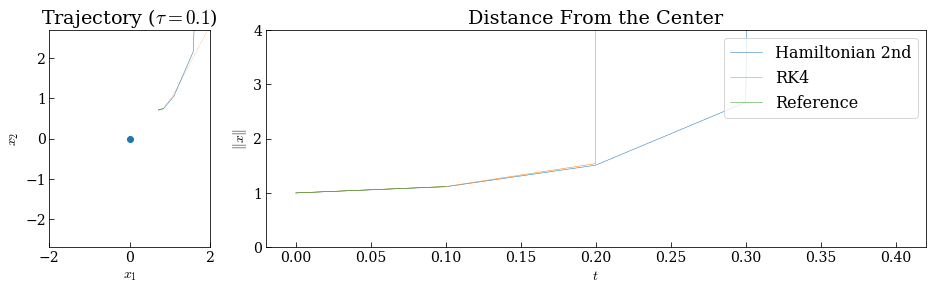

In [43]:
tpk = CosmologicalModel(-1/3, α=1)
init = init_angles(tpk,np.pi/4.)
dt = 0.1
tf = 50

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [
    init
    ]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0, q0, s0]), tspan)
    r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    drr = np.empty(len(r.t), dtype=np.float64)
    
    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
                
    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:4])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.5,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")

    axo.plot(r.y[2],
             r.y[3],
             c='C2',
             linewidth=0.5, label="Reference")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             dc,
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.5, label="RK4")
    
    for i in range(len(r.t)):
        dist=np.linalg.norm(r.y.T[:,2:4][i])
        drr[i]=dist
    
    axe.plot(r.t,
             drr,
             linewidth=0.5, label="Reference")

    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
#     fig.savefig(f"images/TPK01.pdf", bbox_inches='tight')
    fig.show()

<ipython-input-10-6d0b55be9bee>:11: RuntimeWarning: overflow encountered in exp
  self.Fprime = lambda x: - x / np.sqrt(6) * np.exp(-x/np.sqrt(6)) - x * np.sqrt(6) * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in multiply
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6d0b55be9bee>:10: RuntimeWarning: overflow encountered in exp
  self.F = lambda x: np.exp(-x/np.sqrt(6)) - 0.5 * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in double_scalars
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in matmul
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in matmul
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6

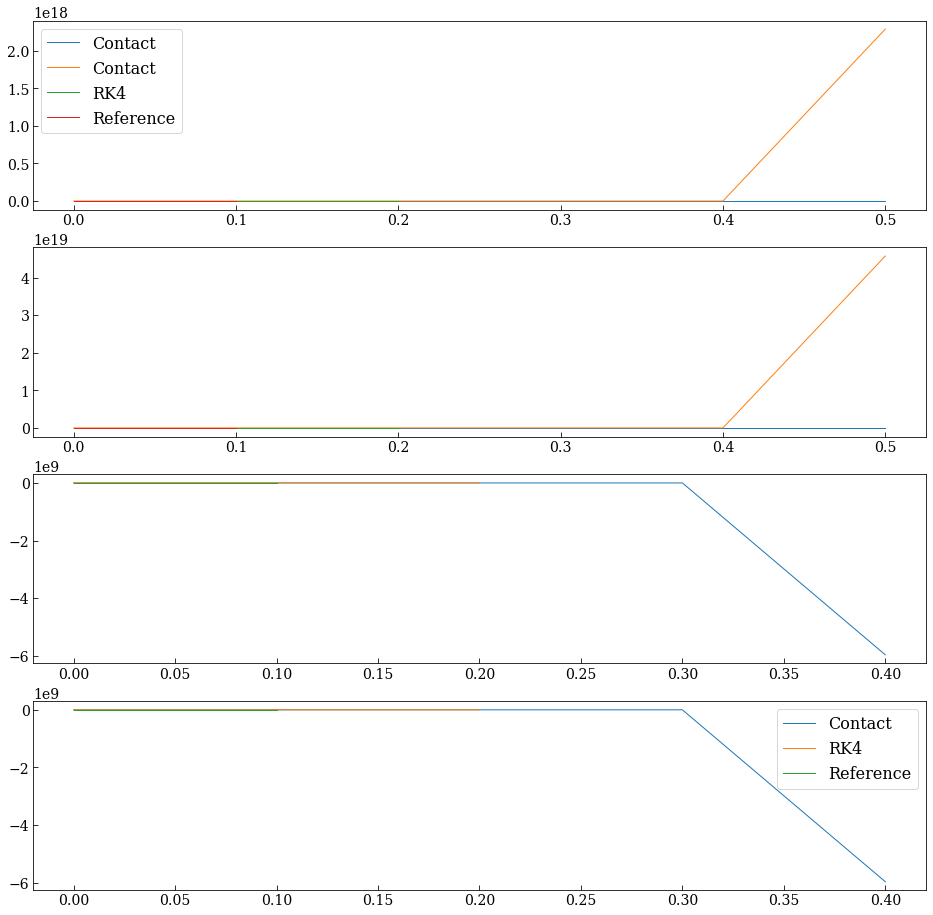

In [44]:
for (p0, q0, s0) in [
    init
    ]:
    fig = plt.figure(figsize=(16,16))
    
    sol, sols, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
    r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    plt.subplot(411)
    plt.plot(tspan, sol[:,1], label="Contact", linewidth=1)
    plt.plot(tspan, solrk.T[1], label="RK4", linewidth=1)
    plt.plot(r.t, r.y[1], label="Reference", linewidth=1)
    plt.legend()
    plt.subplot(412)
    plt.plot(tspan, sol[:,0], label="Contact", linewidth=1)
    plt.plot(tspan, solrk.T[0], label="RK4", linewidth=1)
    plt.plot(r.t, r.y[0], label="Reference", linewidth=1)
    plt.subplot(413)
    plt.plot(tspan, [tpk.energy(p,q,s,t) for p,q,s,t in zip(sol[:,0], sol[:,1], sols, tspan)], label="Contact", linewidth=1)
    plt.plot(tspan, [tpk.energy(p,q,s,t) for p,q,s,t in zip(solrk[:,0:2], solrk[:,2:4], solrk.T[4], tspan)], label="RK4", linewidth=1)
    plt.plot(r.t, [tpk.energy(p,q,s,t) for p,q,s,t in zip(r.y.T[:,0:2], r.y.T[:,2:4], r.y.T[:,4], r.t)], label="Reference", linewidth=1)
    plt.subplot(414)
    cut=100
    plt.plot(tspan[:cut], [tpk.energy(p,q,s,t) for p,q,s,t in zip(sol[:,0][:cut], sol[:,1], sols, tspan)], label="Contact", linewidth=1)
    plt.plot(tspan[:cut], [tpk.energy(p,q,s,t) for p,q,s,t in zip(solrk[:,0:2][:cut], solrk[:,2:4], solrk.T[4], tspan)], label="RK4", linewidth=1)
    plt.plot(r.t[:cut], [tpk.energy(p,q,s,t) for p,q,s,t in zip(r.y.T[:,0:2][:cut], r.y.T[:,2:4], r.y.T[:,4], r.t)], label="Reference", linewidth=1)
    plt.legend()

    plt.show()


<ipython-input-10-6d0b55be9bee>:11: RuntimeWarning: overflow encountered in exp
  self.Fprime = lambda x: - x / np.sqrt(6) * np.exp(-x/np.sqrt(6)) - x * np.sqrt(6) * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in multiply
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6d0b55be9bee>:10: RuntimeWarning: overflow encountered in exp
  self.F = lambda x: np.exp(-x/np.sqrt(6)) - 0.5 * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in double_scalars
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in add
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-45-bec3acd62383>:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


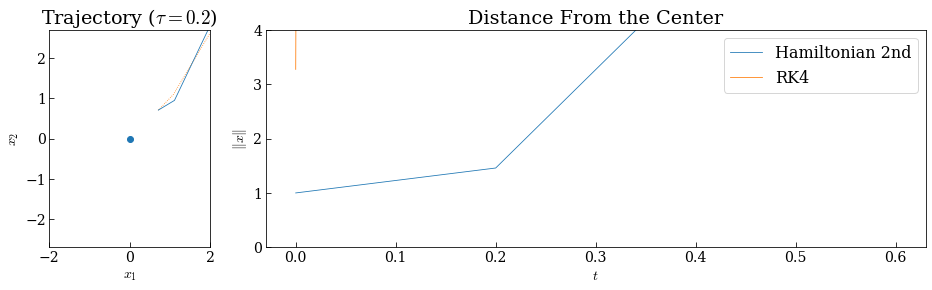

In [45]:
dt = 0.2
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0, s0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
                
    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
        
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    
    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
        
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
        
    axe.plot(tspan,
             dc,
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.8, label="RK4")    

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')
    
    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK02.pdf", bbox_inches='tight')

    fig.show()

<ipython-input-10-6d0b55be9bee>:11: RuntimeWarning: overflow encountered in exp
  self.Fprime = lambda x: - x / np.sqrt(6) * np.exp(-x/np.sqrt(6)) - x * np.sqrt(6) * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in multiply
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in add
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6d0b55be9bee>:10: RuntimeWarning: overflow encountered in exp
  self.F = lambda x: np.exp(-x/np.sqrt(6)) - 0.5 * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in double_scalars
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:25: RuntimeWarning: overflow encountered in double_scalars
  return .5 * np.linalg.norm(v)**2 - self.V(q,t) - self.f(t) * z**2 / 2
<ipython-input-46-ecbcb2d3dd7c>

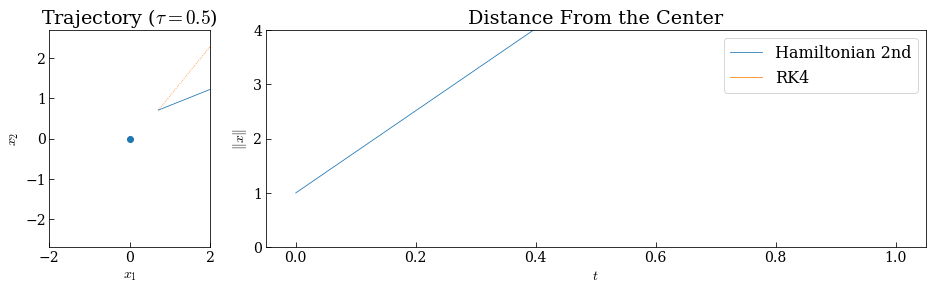

In [46]:
dt = 0.5
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=int(tf/dt)
dc = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist

    for i in range(steps):
        dist=np.linalg.norm(solrk[i][2:])
        drk[i]=dist
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
    
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")
    
    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")

    axe.plot(tspan,
             dc,
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             drk,
             linewidth=0.8, label="RK4")    

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')
    
    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")    
    
    fig.savefig(f"images/TPK05.pdf", bbox_inches='tight')

    fig.show()

<ipython-input-10-6d0b55be9bee>:11: RuntimeWarning: overflow encountered in exp
  self.Fprime = lambda x: - x / np.sqrt(6) * np.exp(-x/np.sqrt(6)) - x * np.sqrt(6) * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in multiply
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-10-6d0b55be9bee>:10: RuntimeWarning: overflow encountered in exp
  self.F = lambda x: np.exp(-x/np.sqrt(6)) - 0.5 * np.exp(2*x/np.sqrt(6))
<ipython-input-10-6d0b55be9bee>:17: RuntimeWarning: invalid value encountered in double_scalars
  return self.α * (self.F(self.c2 @ q) + self.F(self.x1 @ q) + self.F(self.x2 @ q))
<ipython-input-10-6d0b55be9bee>:20: RuntimeWarning: invalid value encountered in add
  return self.α * (self.c2 * self.Fprime(self.c2 @ q)
<ipython-input-52-801a096b4807>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


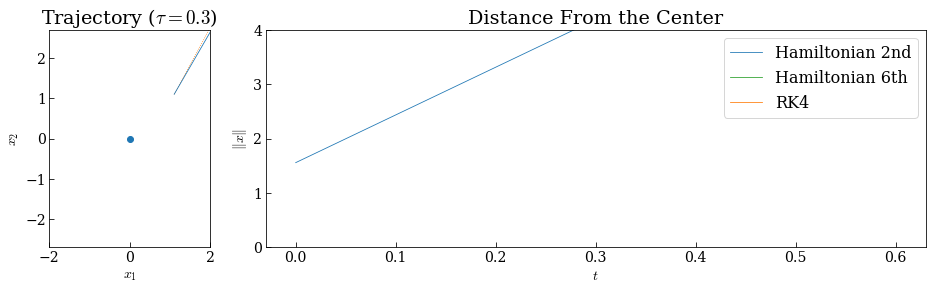

In [52]:
dt = 0.3
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=len(tspan)
dc = np.empty(steps, dtype=np.float64)
dc6 = np.empty(steps, dtype=np.float64)
drk = np.empty(steps, dtype=np.float64)

for (p0, q0, s0) in [init_angles(tpk,np.pi/4, 1.0)]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    sol, sols, tspan = ic.integrate(ic.step1q, tpk, tspan, p0, q0, s0)
    sol6, sols6, _ = ic.integrate(ic.step6q, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)

    #distance
    for i in range(steps):
        dist=np.sqrt(sol[i,1,0]*sol[i,1,0] + sol[i,1,1]*sol[i,1,1])
        dc[i]=dist
        dist6=np.sqrt(sol6[i,1,0]*sol6[i,1,0] + sol6[i,1,1]*sol6[i,1,1])
        dc6[i]=dist6
        distrk=np.linalg.norm(solrk[i][2:])
        drk[i]=distrk
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")
    
    axo.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             ':', linewidth=0.8,
             c='C1',
             label="RK4")
    
    axo.plot(sol[:,1,0],
             sol[:,1,1],
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axo.plot(sol6[:,1,0],
             sol6[:,1,1],
             c='C2',
             linewidth=0.8, label="Hamiltonian 6th")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)
    
    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")
    
    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")

    axe.plot(tspan,
             dc,
             c='C0',
             linewidth=0.8, label="Hamiltonian 2nd")
    
    axe.plot(tspan,
             dc6,
             c='C2',
             linewidth=0.8, label="Hamiltonian 6th")
    
    axe.plot(tspan,
             drk,
             c='C1',
             linewidth=0.8, label="RK4")

    axe.set_ylim(0, 4)    
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    fig.savefig(f"images/TPK03prec.pdf", bbox_inches='tight')

    fig.show()